# Bag of Words

In [ ]:
!pip install lime
!pip install transformers
!pip install -q kaggle
!pip install nltk

In [250]:
## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

In [251]:
# upload kaggle.json file
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"mraliamani","key":"8de7b6a74daa2b154f80841ff721de64"}'}

In [252]:
# news category dataset from kaggle
!mkdir news_category_dataset
!unzip "archive.zip" -d news_category_dataset

mkdir: cannot create directory ‘news_category_dataset’: File exists
unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [253]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
ref                                                      title                                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ---------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide     Covid Cases and Deaths WorldWide           8KB  2023-02-01 12:22:51          11179        370  1.0              
naveenkumar20bps1137/walmart-sales-analysis              WALMART SALES ANALYSIS                   119KB  2023-03-03 18:02:11           1617         47  0.9411765        
datascientistanna/customers-dataset                      Shop Customer Data                        23KB  2023-02-07 18:42:21           9636        219  1.0              
ulrikthygepedersen/co2-emissions-by-country              CO2 Emissions                   

In [254]:
# !kaggle competitions download -c 'News Category Dataset'
!kaggle datasets download -d rmisra/news-category-dataset
!mkdir news_category_dataset
!unzip "news-category-dataset.zip" -d news_category_dataset

news-category-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘news_category_dataset’: File exists
Archive:  news-category-dataset.zip
replace news_category_dataset/News_Category_Dataset_v3.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: news_category_dataset/News_Category_Dataset_v3.json  


In [255]:
lst_dics = []
with open('/content/news_category_dataset/News_Category_Dataset_v3.json', mode='r', errors='ignore') as json_file:
  for dic in json_file:
    lst_dics.append(json.loads(dic))

lst_dics[0]

{'link': 'https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9',
 'headline': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters',
 'category': 'U.S. NEWS',
 'short_description': 'Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.',
 'authors': 'Carla K. Johnson, AP',
 'date': '2022-09-23'}

In [256]:
dtf = pd.DataFrame(lst_dics)
dtf = dtf[dtf['category'].isin(['ENTERTAINMENT', 'POLITICS', 'TECH'])][['category', 'headline']]
dtf = dtf.rename(columns={'category':'y', 'headline':"text"})
dtf.sample(5)

,y,text
75926,ENTERTAINMENT,Gwyneth Paltrow Shares Stunning Selfie With Lo...
56337,POLITICS,Mike Pence: The Birther Issue Is Over
15000,POLITICS,Feds Arrest Arizona Man For Selling Armor-Pier...
129080,ENTERTAINMENT,The World Will End This Summer -- According to...
47793,POLITICS,"Lest We Forget, America Suffered Its Deadliest..."


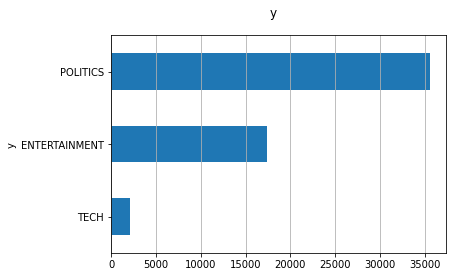

In [257]:
fig, ax = plt.subplots()
fig.suptitle('y', fontsize=12)
dtf['y'].reset_index().groupby('y').count().sort_values(by=
        'index').plot(kind='barh', legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [258]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
  """
  preprocess a string
  parameters:
    text (str): name of the column containing text
    lst_stopwords (list): list of stopwords to remove
    flg_stemm (bool): whether stemming is to be applied
    flg_lemm (bool): whether lemmatization is to be applied
  return:
    cleaned_text
  """
  # cleaning: lowercase, remove punctuations and strip
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

  # tokenize
  lst_text = text.split()

  # remove stopwords
  if lst_stopwords is not None:
    lt_words = [word for word in lst_text if word not in 
                lst_stopwords]
  
  # stemming
  if flg_stemm:
    ps = nltk.stem.porter.PorterStemmer()
    lst_text = [ps.stem(word) for word in lst_text]

  # lemmatization
  if flg_lemm:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]

  text = " ".join(lst_text)
  return text

In [ ]:
nltk.download('all')

In [260]:
lst_stopwords = nltk.corpus.stopwords.words("english")
len(lst_stopwords)

179

In [261]:
dtf['text_clean'] = dtf['text'].apply(lambda x:
                                      utils_preprocess_text(x, flg_stemm=False, flg_lemm=True,
                                                            lst_stopwords=lst_stopwords))
dtf.head()

,y,text,text_clean
13,TECH,Twitch Bans Gambling Sites After Streamer Scam...,twitch ban gambling site after streamer scam f...
20,ENTERTAINMENT,Golden Globes Returning To NBC In January Afte...,golden globe returning to nbc in january after...
21,POLITICS,Biden Says U.S. Forces Would Defend Taiwan If ...,biden say u force would defend taiwan if china...
24,POLITICS,‘Beautiful And Sad At The Same Time’: Ukrainia...,beautiful and sad at the same time ukrainian c...
28,ENTERTAINMENT,James Cameron Says He 'Clashed' With Studio Be...,james cameron say he clashed with studio befor...


In [262]:
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=.3)
y_train = dtf_train['y'].values
y_test = dtf_test['y'].values

In [263]:
# basic BoW
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000,
                                                     ngram_range=(1, 2))

# Tf_Idf
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000,
                                                    ngram_range=(1, 2))

In [264]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1.0, 'Sparse Matrix Sample')

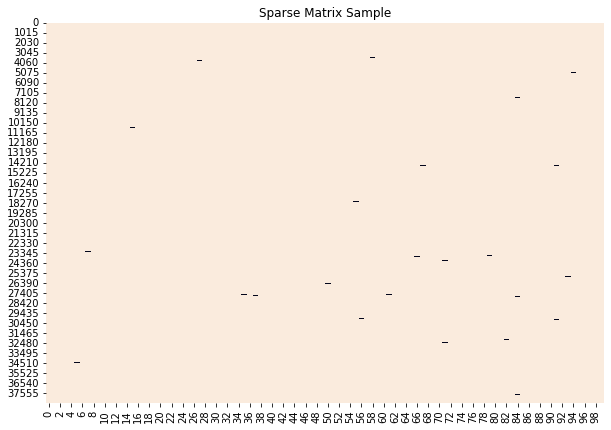

In [265]:
plt.figure(figsize=(10, 7))
sns.heatmap(X_train.todense()
  [:, np.random.randint(0, X_train.shape[1], 100)] == 0, 
  vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [266]:
def show_heatmap(data):
  plt.figure(figsize=(10, 7))
  sns.heatmap(X_train.todense()
              [:, np.random.randint(0, X_train.shape[1], 100)] == 0, 
              vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [267]:
word = 'new york'
dic_vocabulary[word]

5634

In [268]:
y = dtf_train['y']
X_names = vectorizer.get_feature_names_out()
p_value_limit = .95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
  chi2, p = feature_selection.chi2(X_train, y==cat)
  dtf_features = dtf_features.append(pd.DataFrame(
      {'feature':X_names, 'score':1-p, 'y':cat}
  ))
  dtf_features = dtf_features.sort_values(['y', 'score'],
                                          ascending=[True, False])
  dtf_features = dtf_features[dtf_features['score'] > p_value_limit]
X_names = dtf_features['feature'].unique().tolist()

In [269]:
for cat in np.unique(y):
  print('# {}:'.format(cat))
  print("  . selected features:",
        len(dtf_features[dtf_features['y']==cat]))
  print("  . top features:", ",".join(
      dtf_features[dtf_features['y']==cat]['feature'].values[:10]
  ))
  print(" ")

# ENTERTAINMENT:
  . selected features: 2925
  . top features: actor,album,award,box,box office,celebrity,clinton,dead,dead at,donald
 
# POLITICS:
  . selected features: 3056
  . top features: actor,album,apple,award,box,box office,clinton,dead,democrat,donald
 
# TECH:
  . selected features: 410
  . top features: amazon,android,app,apple,apple rumor,apps,bug,computer,content,cyber
 


In [270]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

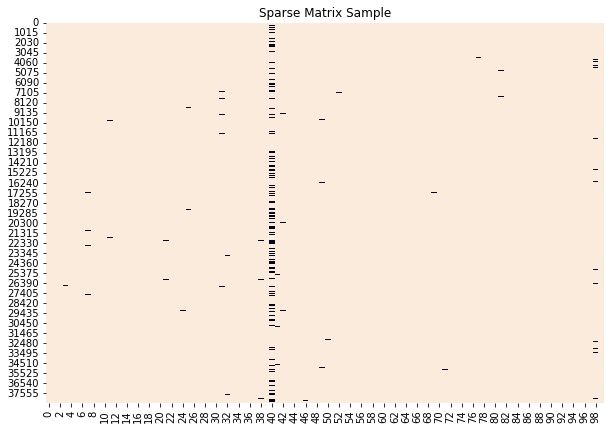

In [271]:
show_heatmap(X_train)

In [272]:
classifier = naive_bayes.MultinomialNB()

In [273]:
model = pipeline.Pipeline([('vectorizer', vectorizer),
                           ('classifier', classifier)])

model['classifier'].fit(X_train, y_train)
X_test = dtf_test['text_clean'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.91
AUC: 0.97
Details: 
               precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.86      0.88      5188
     POLITICS       0.91      0.97      0.94     10683
         TECH       0.94      0.25      0.39       650

     accuracy                           0.91     16521
    macro avg       0.92      0.69      0.74     16521
 weighted avg       0.91      0.91      0.90     16521



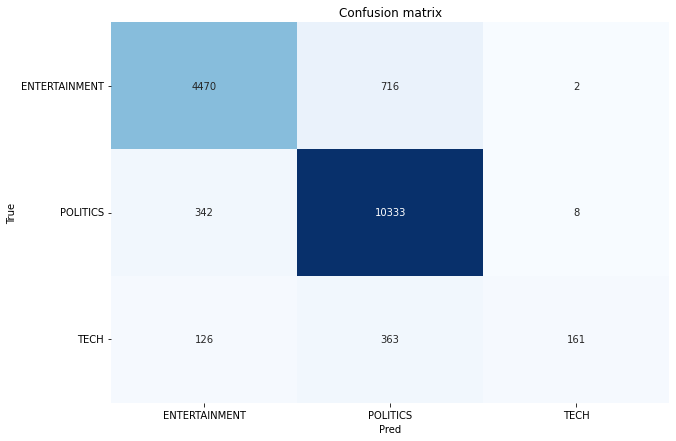

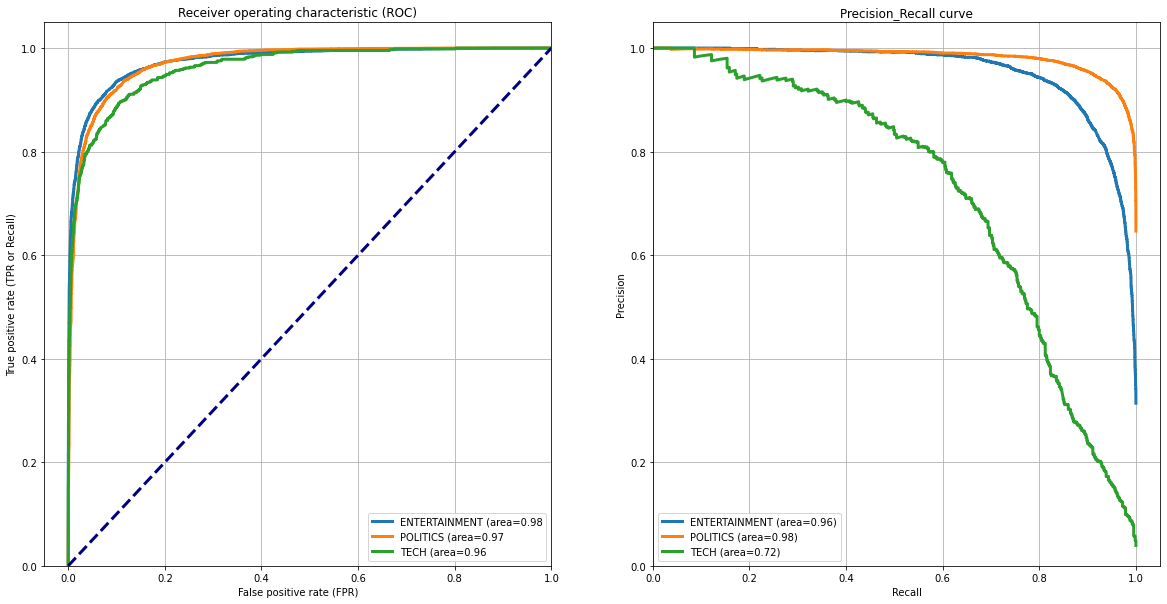

In [274]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# metrics
accuracy = accuracy_score(y_test, predicted)
auc_score = roc_auc_score(y_test, predicted_prob, 
                                  multi_class='ovr')
print("Accuracy: {}".format(round(accuracy, 2)))
print("AUC: {}".format(round(auc_score, 2)))
print(f"Details: \n{classification_report(y_test, predicted)}")

# plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', title='Confusion matrix', 
       xticklabels=classes, yticklabels=classes)
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
# plot roc
for i in range(len(classes)):
  fpr, tpr, threshold = roc_curve(y_test_array[:,i],
                                          predicted_prob[:,i])
  ax[0].plot(fpr, tpr, lw=3, 
             label='{0} (area={1:.2f}'.format(classes[i],
                                              auc(fpr, tpr)))
ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-.05, 1], ylim=[0, 1.05],
          xlabel='False positive rate (FPR)',
          ylabel='True positive rate (TPR or Recall)',
          title='Receiver operating characteristic (ROC)')
ax[0].legend(loc='lower right')
ax[0].grid()

# plot precision-recall curve
for i in range(len(classes)):
  precision, recall, thresholds = precision_recall_curve(
      y_test_array[:,i], predicted_prob[:,i]
  )
  ax[1].plot(recall, precision, linewidth=3, 
              label='{0} (area={1:.2f})'.format(classes[i],
                                                auc(recall, precision)))
ax[1].set(xlim=[0, 1.05], ylim=[0, 1.05], xlabel='Recall',
            ylabel='Precision',
            title='Precision_Recall curve')
ax[1].legend(loc='best')
ax[1].grid(True)
plt.show()

In [275]:
i = 0
txt_instance = dtf_test['text'].iloc[i]

print("True:", y_test[i], "Pred:", predicted[i], "Prob:", 
      round(np.max(predicted_prob[i]), 2))

# explainer
explainer = lime_text.LimeTextExplainer(class_names=
                                        np.unique(y_train))
explained = explainer.explain_instance(txt_instance,
                                       model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: POLITICS Pred: POLITICS Prob: 0.99


# Word Embedding

In [276]:
nlp = gensim_api.load('word2vec-google-news-300')

In [299]:
corpus = dtf_train['text_clean']
lst_corpus = []

# list of list of unigrams
for string in corpus:
  lst_words = string.split()
  lst_grams = [" ".join(lst_words[i: i+1])
                         for i in range(0, len(lst_words), 1)]
  lst_corpus.append(lst_grams)

# bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                                                 delimiter=" ".encode(),
                                                 min_count=5, 
                                                 threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus],
                                                  delimiter=" ".encode(),
                                                  min_count=5,
                                                  threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [300]:
# fit
nlp = gensim.models.word2vec.Word2Vec(lst_corpus,
                                      size=300,
                                      window=8, # mean length of text in the corpus
                                      min_count=1,
                                      sg=1, # skipgram instead of continuous BoW
                                      iter=30)

In [301]:
word = 'data'
nlp[word].shape

<ipython-input-301-725ffee0765a>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  nlp[word].shape


(300,)

<ipython-input-302-e1c2168a5b97>:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  nlp.most_similar(word, topn=20)]
<ipython-input-302-e1c2168a5b97>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = nlp[tot_words]
/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


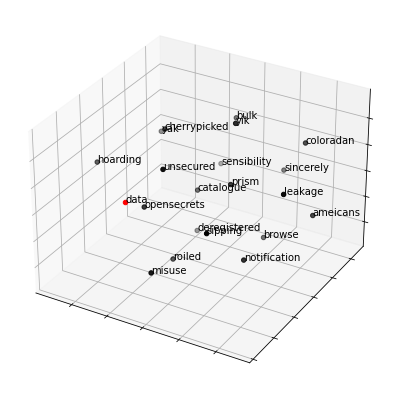

In [302]:
word = "data"
fig = plt.figure(figsize=(10, 7))
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=20, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [303]:
# tokenize
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ',
                                       oov_token='NaN',
                                       filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

# sequence
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

# padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq,
                                             maxlen=15,
                                             padding='post',
                                             truncating='post')

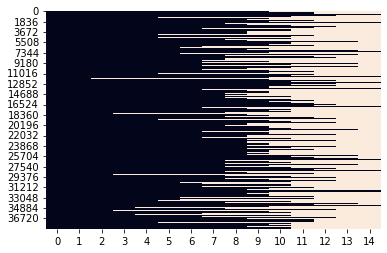

In [304]:
sns.heatmap(X_train == 0, vmin=0, vmax=1, cbar=False)
plt.show()

In [305]:
i = 0

# list of text
len_txt = len(dtf_train['text_clean'].iloc[i].split())
print("from: ", dtf_train['text_clean'].iloc[i], "| len:", len_txt)

# sequence of tokens
len_tokens = len(X_train[i])
print("to: ", X_train[i], "|len:", len(X_train[i]))

# vocabulary
print("check: ", dtf_train['text_clean'].iloc[i].split()[0], 
      "\nidx in vocabulary: ", 
      dic_vocabulary[dtf_train['text_clean'].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0: 5]), 
      " (padding element, 0)")

from:  liam payne share touching note on fatherhood after birth of son | len: 11
to:  [ 2096  6340   344  1458  1486     9 10072    23   877     6   335     0
     0     0     0] |len: 15
check:  liam 
idx in vocabulary:  2096
vocabulary:  {'NaN': 1, 'the': 2, 'to': 3, 'trump': 4, 'a': 5}  (padding element, 0)


In [306]:
corpus = dtf_test["text_clean"]

# ngrams
lst_corpus = []
for string in corpus:
  lst_words = string.split()
  lst_grams = [" ".join(lst_words[i: i+1]) for i in range(0, len(lst_words), 1)]
  lst_corpus.append(lst_grams)

# bigrams and trigrams
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])

# text to sequence with the fitted vectorizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

# padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
                                            padding='post', truncating='post')

<AxesSubplot:>

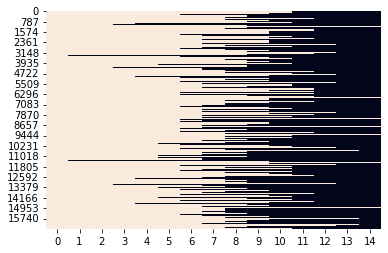

In [307]:
sns.heatmap(X_test, vmin=0, vmax=1, cbar=False)

In [308]:
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word, idx in dic_vocabulary.items():
  try:
    embeddings[idx] = nlp[word]
  except:
    pass

<ipython-input-308-6f06f03bb0c8>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] = nlp[word]


In [309]:
embeddings.shape

(23825, 300)

In [310]:
word = 'data'
print('dic[word]:', dic_vocabulary[word], '|idx')
print('embeddings[idx]:', embeddings[dic_vocabulary[word]].shape,
      '|vector')

dic[word]: 654 |idx
embeddings[idx]: (300,) |vector


In [311]:
def attention_layer(inputs, neurons):
  x = layers.Permute((2,1))(inputs)
  x = layers.Dense(neurons, activation='softmax')(x)
  x = layers.Permute((2,1), name='attention')(x)
  x = layers.multiply([inputs, x])
  return x

x_in = layers.Input(shape=(15,))
x = layers.Embedding(input_dim=embeddings.shape[0],
                     output_dim=embeddings.shape[1],
                     weights=[embeddings],
                     input_length=15,
                     trainable=False)(x_in)
x = attention_layer(x, neurons=15)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=.2,
                                     return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=.2))(x)
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
model = models.Model(x_in, y_out)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 15, 300)      7147500     ['input_6[0][0]']                
                                                                                                  
 permute_5 (Permute)            (None, 300, 15)      0           ['embedding_5[0][0]']            
                                                                                                  
 dense_31 (Dense)               (None, 300, 15)      240         ['permute_5[0][0]']              
                                                                                           

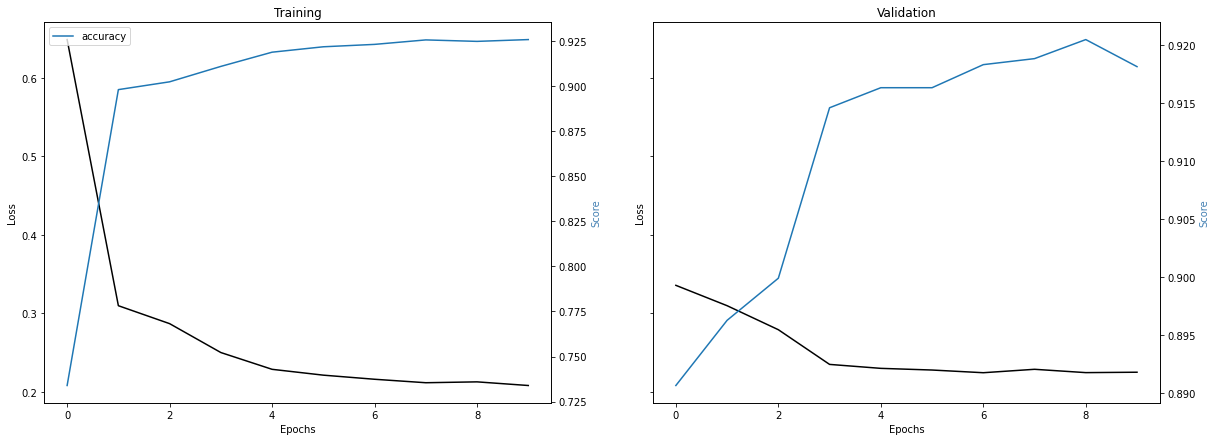

In [312]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 7))

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
# test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in
             predicted_prob]

## plot the confusion matrix and roc and precision_recall curve

Accuracy: 0.89
AUC: 0.96
Details: 
               precision    recall  f1-score   support

ENTERTAINMENT       0.87      0.83      0.85      5188
     POLITICS       0.90      0.94      0.92     10683
         TECH       0.81      0.51      0.62       650

     accuracy                           0.89     16521
    macro avg       0.86      0.76      0.80     16521
 weighted avg       0.89      0.89      0.89     16521



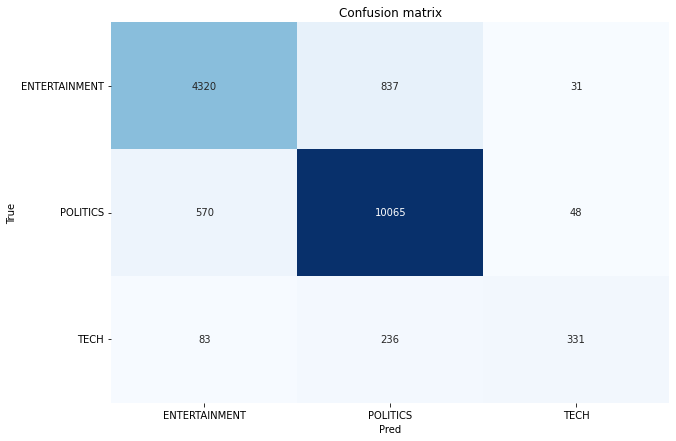

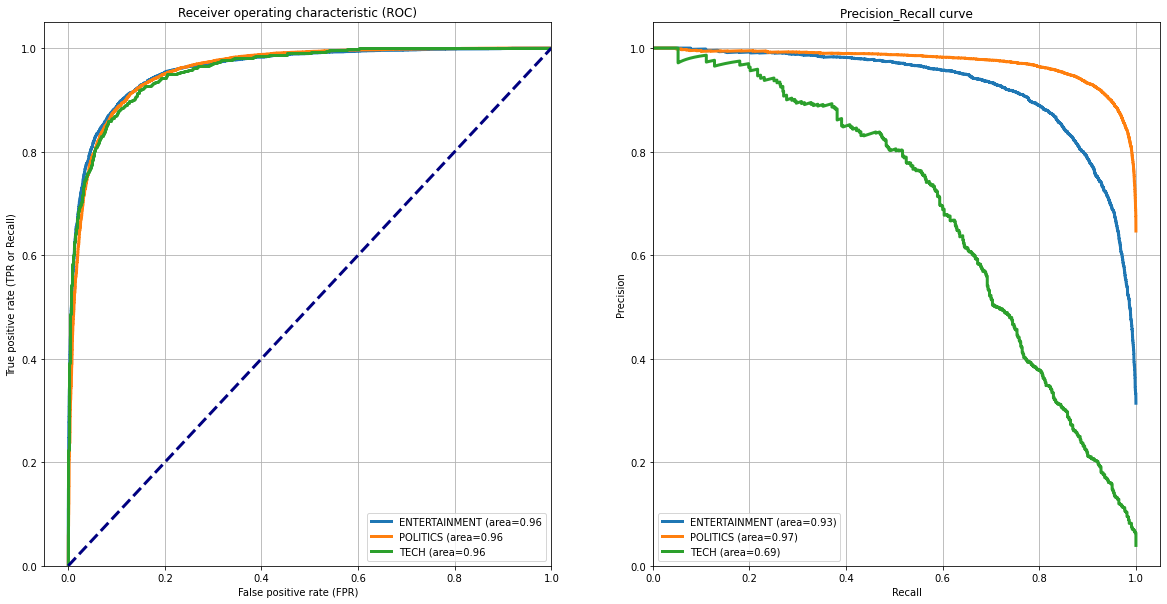

In [315]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# metrics
accuracy = accuracy_score(y_test, predicted)
auc_score = roc_auc_score(y_test, predicted_prob, 
                                  multi_class='ovr')

print("Accuracy: {}".format(round(accuracy, 2)))
print("AUC: {}".format(round(auc_score, 2)))

# Print classification report
print(f"Details: \n{classification_report(y_test, predicted)}")

# plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', title='Confusion matrix', 
       xticklabels=classes, yticklabels=classes)
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
# plot roc
for i in range(len(classes)):
  fpr, tpr, threshold = roc_curve(y_test_array[:,i],
                                          predicted_prob[:,i])
  ax[0].plot(fpr, tpr, lw=3, 
             label='{0} (area={1:.2f}'.format(classes[i],
                                              auc(fpr, tpr)))
ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-.05, 1], ylim=[0, 1.05],
          xlabel='False positive rate (FPR)',
          ylabel='True positive rate (TPR or Recall)',
          title='Receiver operating characteristic (ROC)')
ax[0].legend(loc='lower right')
ax[0].grid()

# plot precision-recall curve
for i in range(len(classes)):
  precision, recall, thresholds = precision_recall_curve(
      y_test_array[:,i], predicted_prob[:,i]
  )
  ax[1].plot(recall, precision, linewidth=3, 
              label='{0} (area={1:.2f})'.format(classes[i],
                                                auc(recall, precision)))
ax[1].set(xlim=[0, 1.05], ylim=[0, 1.05], xlabel='Recall',
            ylabel='Precision',
            title='Precision_Recall curve')
ax[1].legend(loc='best')
ax[1].grid(True)
plt.show()

True:  POLITICS Pred:  POLITICS | Prob:  0.98


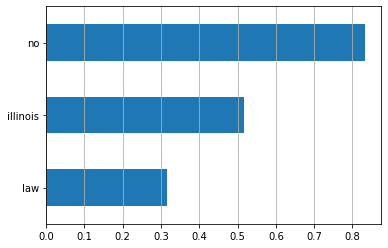

Text with highlihjted words


In [313]:
i = 0
text_instance = dtf_test['text'].iloc[i]

print('True: ', y_test[i], 'Pred: ', predicted[i], '| Prob: ', round(np.max(predicted_prob[i]), 2))

# 1.preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]', '', txt_instance.lower().strip())]:
  lst_words = string.split()
  lst_grams = [' '.join(lst_words[i: i+1]) for  i in range(0, 
                                                            len(lst_words), 1)]
  lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(corpus), maxlen=15,
    padding='post', truncating='post'
)

# 2.attention weights
layer = [layer for layer in model.layers if 'attention' in
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()

# 3.rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(
    np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n, idx in enumerate(X_instance[0]) if idx != 0]
dic_word_weight = {word:weights[n] for n, word in 
                   enumerate(lst_corpus[0]) if word in
                   tokenizer.word_index.keys()}

# 4.barplot
if len(dic_word_weight) > 0:
  dtf = pd.DataFrame.from_dict(dic_word_weight, orient='index',
                               columns=['score'])
  dtf.sort_values(by='score', ascending=True).tail(3).plot(kind='barh',
                                               legend=False).grid(axis='x')
  plt.show()
else:
  print('No word recognized!')

# 5.html visualization
text = []
for word in lst_corpus[0]:
  weight = dic_word_weight.get(word)
  if weight is not None:
    text.append('<br><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></br>')
  else:
    text.append(word)
text = ' '.join(text)

# 6.visualize
print("\033[1m" + "Text with highlihjted words")
from IPython.core.display import display, HTML
display(HTML(text))

# Bert

In [290]:
txt = 'bank river'

# bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

# return hidden layer with embeddings
input_ids = np.array(tokenizer.encode(txt))[None,:]
embedding = nlp(input_ids)
embedding[0][0]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.34245968,  0.05200436, -0.2565389 , ..., -0.24441774,
         0.05279814,  0.44900668],
       [-0.38362497, -0.66715163, -0.35021335, ..., -0.10210493,
        -0.21629445, -0.29299957],
       [-0.3499616 , -0.08317098, -0.98768336, ...,  0.06963326,
        -0.49453   , -0.1608825 ],
       [ 0.7392344 ,  0.07391967, -0.45680934, ..., -0.0241577 ,
        -0.7649662 , -0.28110713]], dtype=float32)>

In [291]:
# distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', 
                                                       do_lower_case=True)

In [292]:
corpus = dtf_train["text"]
maxlen = 50

# add special tokens
maxqnans = int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
                    " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
                    str(txt).lower().strip()))[:maxqnans])+
                    " [SEP] " for txt in corpus]

# generate masks, idx, and segments
idx, masks, segments = [], [], []
for seq in corpus_tokenized:
    tokens = tokenizer.encode_plus(seq, max_length=maxlen, padding='max_length', truncation=True, return_attention_mask=True)
    idx.append(tokens['input_ids'])
    masks.append(tokens['attention_mask'])
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
            i += 1
    segments.append(temp)

## padding segments
segments = np.asarray([s + [0]*(maxlen-len(s)) for s in segments], dtype='int32')

# feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [293]:
i = 0
print("txt: ", dtf_train["text"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
print("segment: ", X_train[2][i])

txt:  Liam Payne Shares Touching Note On Fatherhood After Birth Of Son
tokenized: ['[CLS]', '[CLS]', 'liam', 'payne', 'shares', 'touching', 'note', 'on', 'father', '#', '#', 'hood', 'after', 'birth', 'of', 'son', '[SEP]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
idx:  [  101   101  8230 13470  6661  7244  3602  2006  2269  1001  1001  7415
  2044  4182  1997  2365   102   102     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
mask:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
segment:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 

In [294]:
corpus = dtf_test["text"]
maxlen = 50

# add special tokens
maxqnans = int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
                    " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
                    str(txt).lower().strip()))[:maxqnans])+
                    " [SEP] " for txt in corpus]

# generate masks, idx, and segments
idx, masks, segments = [], [], []
for seq in corpus_tokenized:
    tokens = tokenizer.encode_plus(seq, max_length=maxlen, padding='max_length', truncation=True, return_attention_mask=True)
    idx.append(tokens['input_ids'])
    masks.append(tokens['attention_mask'])
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
            i += 1
    segments.append(temp)

## padding segments
segments = np.asarray([s + [0]*(maxlen-len(s)) for s in segments], dtype='int32')

# feature matrix
X_test = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [295]:
idx = layers.Input(shape=(50), dtype='int32', name='input_idx')
masks = layers.Input((50), dtype='int32', name='input_mask')
segments = layers.Input((50), dtype='int32', name='input_segments')

# pretrained bert
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
bert_out = nlp([idx, masks, segments])[0]

# fine tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)

# compile
model = models.Model([idx, masks, segments], y_out)
for layer in model.layers[:4]:
  layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 input_segments (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model_6 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_idx[0][0]',              
                                thPoolingAndCrossAt               'input_mask[0][0]',      

In [296]:
idx = layers.Input((50), dtype='int32', name='input_idx')
masks = layers.Input((50), dtype='int32', name='input_masks')

# pretrained bert with config
config = transformers.DistilBertConfig(dropout=.2,
                                       attention_dropout=.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased',
                                                     config=config)
bert_out = nlp(idx, attention_mask=masks)[0]

# fine tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(len(np.unique(y_train)),
                     activation='softmax')(x)

# compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
  layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 tf_distil_bert_model_3 (TFDist  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 50, 768),                                                    
                                 hidden_states=None                                        

In [297]:
## encode y
y_train = dtf_train["y"].values
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

## train
training = model.fit(x=X_train[:2], y=y_train, batch_size=64, # only idx and masks
                     epochs=1, shuffle=True, verbose=1, 
                     validation_split=0.3)

## test
predicted_prob = model.predict(X_test[:2])
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

517/517 [==============================] - 32s 58ms/step


Accuracy: 0.89
AUC: 0.96
Details: 
               precision    recall  f1-score   support

ENTERTAINMENT       0.87      0.83      0.85      5188
     POLITICS       0.90      0.94      0.92     10683
         TECH       0.81      0.51      0.62       650

     accuracy                           0.89     16521
    macro avg       0.86      0.76      0.80     16521
 weighted avg       0.89      0.89      0.89     16521



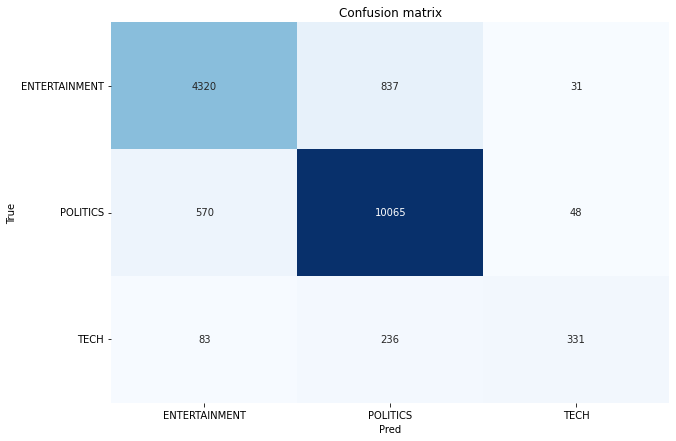

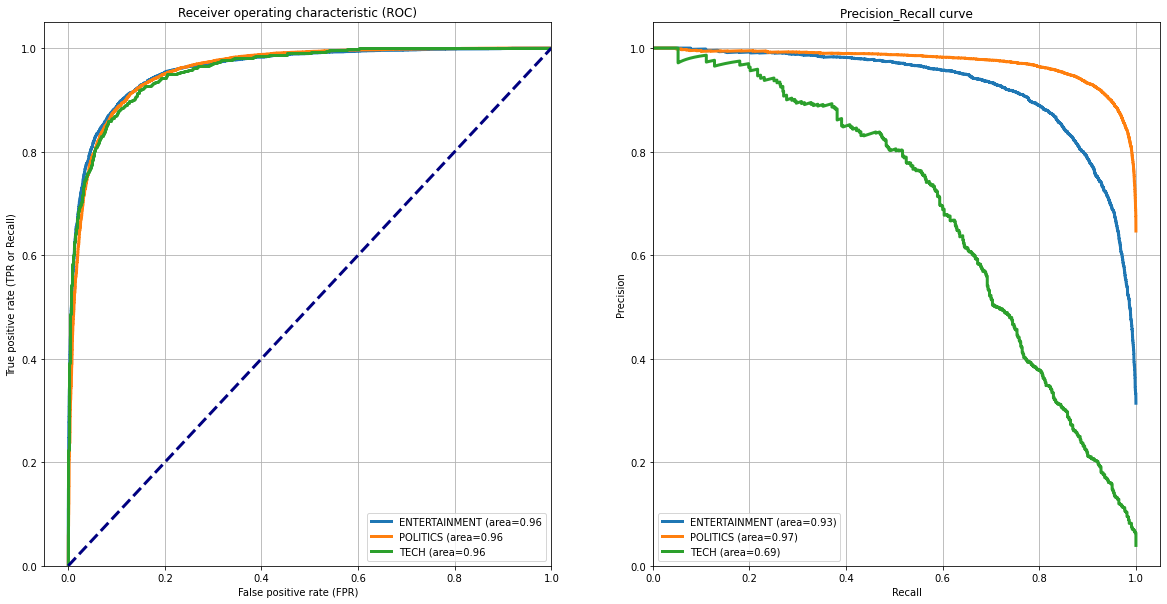

In [298]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# metrics
accuracy = accuracy_score(y_test, predicted)
auc_score = roc_auc_score(y_test, predicted_prob, 
                                  multi_class='ovr')
print("Accuracy: {}".format(round(accuracy, 2)))
print("AUC: {}".format(round(auc_score, 2)))

# Print classification report
print(f"Details: \n{classification_report(y_test, predicted)}")

# plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', title='Confusion matrix', 
       xticklabels=classes, yticklabels=classes)
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
# plot roc
for i in range(len(classes)):
  fpr, tpr, threshold = roc_curve(y_test_array[:,i],
                                          predicted_prob[:,i])
  ax[0].plot(fpr, tpr, lw=3, 
             label='{0} (area={1:.2f}'.format(classes[i],
                                              auc(fpr, tpr)))
ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-.05, 1], ylim=[0, 1.05],
          xlabel='False positive rate (FPR)',
          ylabel='True positive rate (TPR or Recall)',
          title='Receiver operating characteristic (ROC)')
ax[0].legend(loc='lower right')
ax[0].grid()

# plot precision-recall curve
for i in range(len(classes)):
  precision, recall, thresholds = precision_recall_curve(
      y_test_array[:,i], predicted_prob[:,i]
  )
  ax[1].plot(recall, precision, linewidth=3, 
              label='{0} (area={1:.2f})'.format(classes[i],
                                                auc(recall, precision)))
ax[1].set(xlim=[0, 1.05], ylim=[0, 1.05], xlabel='Recall',
            ylabel='Precision',
            title='Precision_Recall curve')
ax[1].legend(loc='best')
ax[1].grid(True)
plt.show()